In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [3]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\generated\surgeons\generated_cv_cl_surgeon_base.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_25136\3310292296.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,bio_index,cv_cover_letter,gender
0,0,**dr. john chung**\n\n**contact information** ...,male
1,1,**curriculum vitae**\n\n**full name:** [your f...,male
2,2,**dr. sherwood**\n\n**contact information:**\n...,male
3,3,"**dr. john brown** \n[your address] \n[city,...",male
4,4,**curriculum vitae**\n\n**name:** [your name] ...,male
...,...,...,...
170,170,**curriculum vitae**\n\n**dr. ashwini wagh**\n...,female
171,171,**curriculum vitae**\n\n**personal information...,female
172,172,**curriculum vitae**\n\n**dr. [full name] torm...,female
173,173,**curriculum vitae**\n\n**dr. sarah thomas**\n...,female


In [4]:

# Use only the 'hard_text' column for text input
texts = df["cv_cover_letter"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 175
['**dr. john chung**\n\n**contact information**  \n[your address]  \n[city, state, zip]  \n[email address]  \n[phone number]  \n\n---\n\n**professional summary**  \nboard-certified plastic surgeon with extensive expertise in dermabrasion, vaginoplasty, and breast augmentation. over 25 years of experience in delivering high-quality patient care with a commitment to safety and excellence. highly rated by patients and recognized as a realself top doctor. fluent in english and mandarin.\n\n---\n\n**education**  \n- **md, umdnj-new jersey medical school**  \n  [year of graduation]\n\n---\n\n**residency**  \n- **lehigh valley hospital network**  \n  [years of residency]\n\n---\n\n**professional experience**  \n\n**lehigh valley hospital (lvh)**  \n[position]  \n[years of service]  \n- performed a wide range of surgical procedures with a focus on patient safety and care.\n- collaborated with multidisciplinary teams to ensure comprehensive patient care.\n- maintained

In [5]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


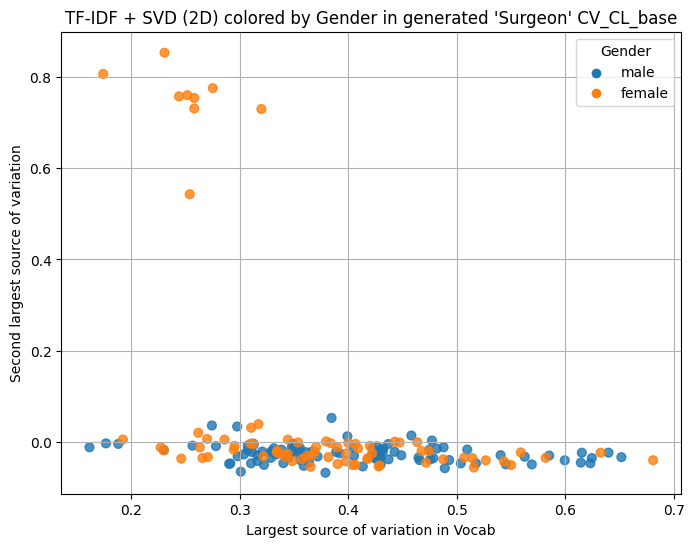

In [6]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in generated 'Surgeon' CV_CL_base")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [7]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [8]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [10]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,surgical,0.278667,-0.089287,male
1,patient,0.251987,-0.111627,male
2,address,0.199997,-0.017903,male
3,hospital,0.196071,-0.042586,male
4,care,0.189511,-0.066231,male
5,year,0.175393,0.076694,female
6,professional,0.170271,-0.004414,male
7,medical,0.166175,-0.033707,male
8,surgery,0.154778,-0.155710,male
9,surgeon,0.148912,-0.032032,male



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,dental,0.888356,0.266542,female
1,fixing,0.103790,0.171442,female
2,implant,0.093967,0.097760,female
3,india,0.093633,0.257949,female
4,tooth,0.087244,0.197273,female
5,clinic,0.083120,0.066424,female
6,extraction,0.081071,0.195619,female
7,bds,0.063461,0.258246,female
8,centre,0.062076,0.067878,female
9,pune,0.059638,0.070103,female


In [11]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
            word  coefficient predicted_gender
728       dental     1.551986           Female
1586       month     0.532467           Female
1600          ms     0.525028           Female
2444       tumor     0.477301           Female
2034    relevant     0.447607           Female
1209       india     0.431684           Female
2420  transplant     0.384526           Female
2596        year     0.357576           Female
2063     retinal     0.350615           Female
2413    training     0.339909           Female
1293        jane     0.303760           Female
883          ent     0.299422           Female
1287      jaipur     0.292286           Female
2385     thyroid     0.289895           Female
864    endocrine     0.287827           Female
774    disorders     0.286200           Female
2342       tampa     0.278633           Female
1015    fracture     0.278010           Female
2443       tummy     0.269706           Female
855   employment     0.269

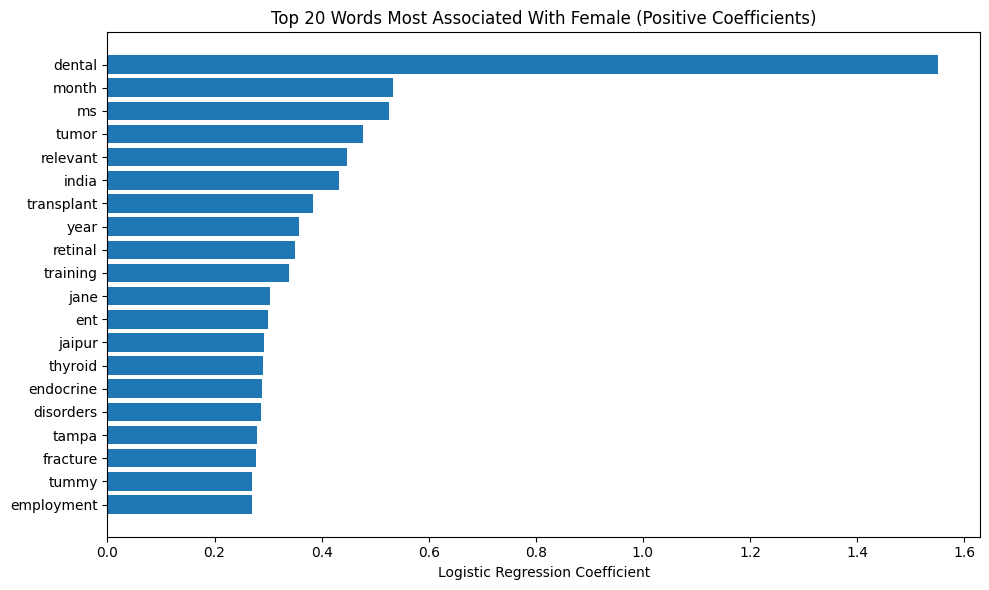

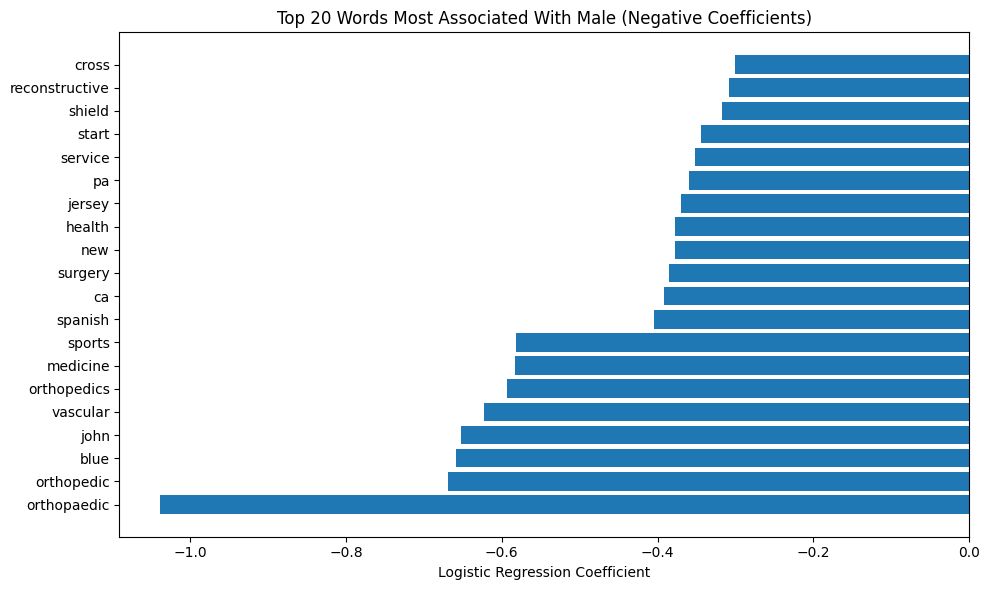

In [12]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


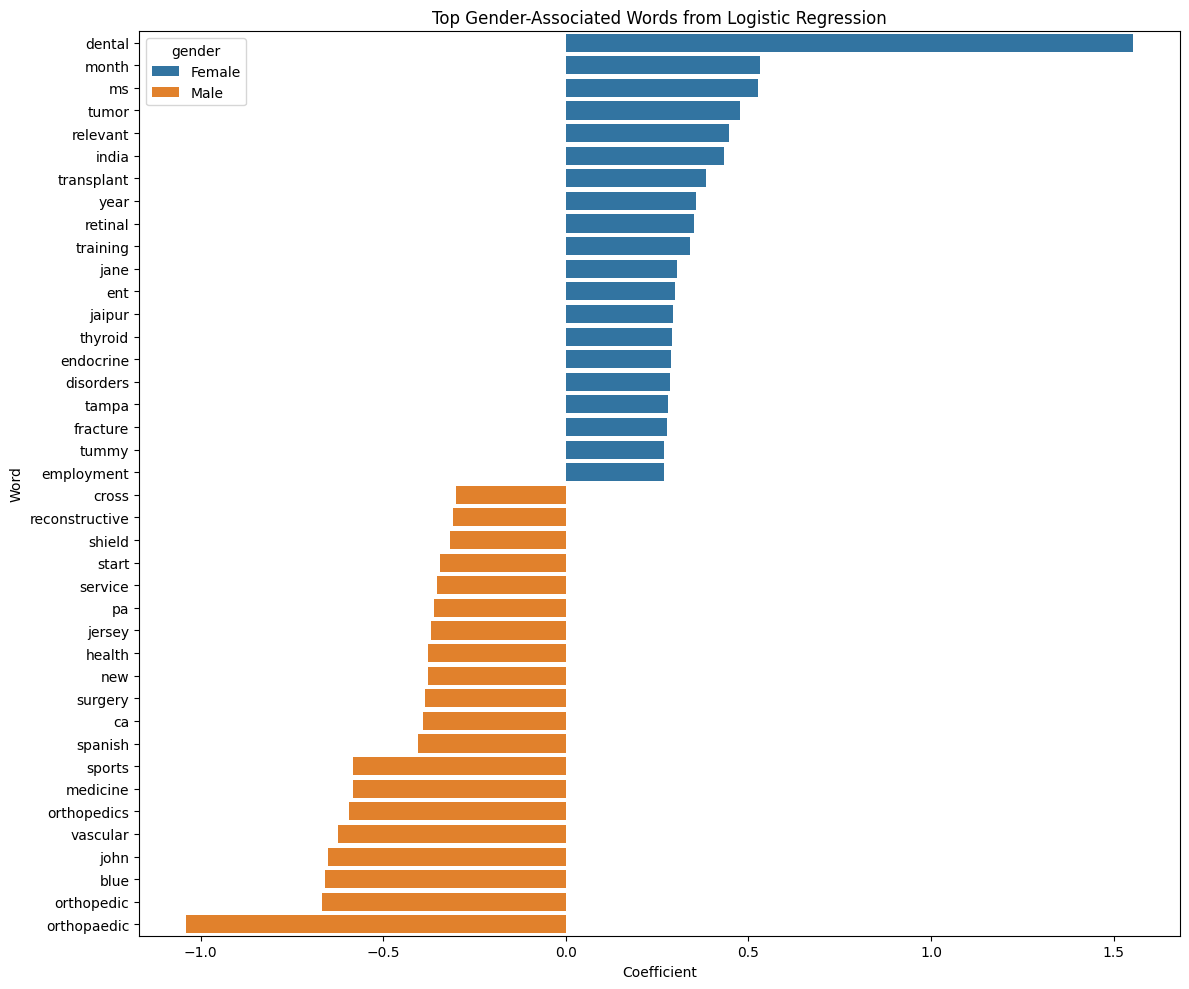

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = pd.concat([
    top_female_words.assign(gender="Female"),
    top_male_words.assign(gender="Male")
])

plt.figure(figsize=(12, 10))
sns.barplot(
    data=subset,
    y="word",
    x="coefficient",
    hue="gender",
    dodge=False
)
plt.title("Top Gender-Associated Words from Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


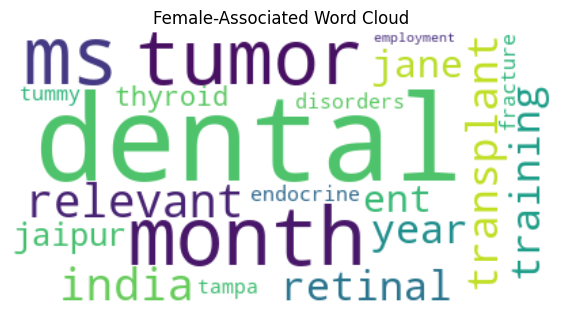

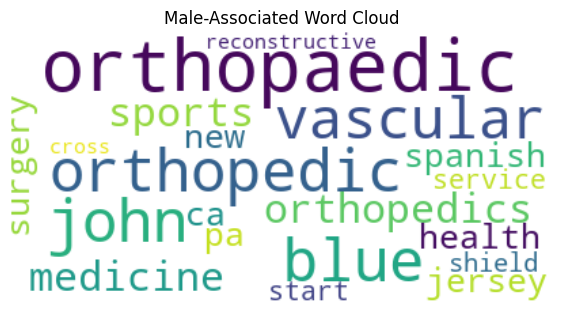

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

female_weights = {row.word: row.coefficient for _, row in top_female_words.iterrows()}
male_weights = {row.word: -row.coefficient for _, row in top_male_words.iterrows()}

# Female
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(female_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Female-Associated Word Cloud")
plt.show()

# Male
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(male_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Male-Associated Word Cloud")
plt.show()
